# 📊 Análise Exploratória de Dados (EDA) – Previsão de Churn Bancário

# ## 1. Contextualização

"""
Este notebook segue o plano de execução do projeto de previsão de churn bancário e incorpora todos os passos documentados no material "Análise Exploratória de Dados – Previsão de Churn Bancário". Ele utiliza a base enriquecida com variáveis derivadas e aplica técnicas como: correlação, distribuição, clusterização, PCA e verificadores de balanceamento.
"""

# ## 2. Imports e Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# ## 3. Leitura da base enriquecida

In [2]:
import os

# Use raw string or forward slashes to fix the path
caminho = r"C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\data\BankChurners.csv"

# Alternative: use forward slashes (works on all platforms)
# caminho = "C:/Users/Iago/OneDrive/Desktop/Projeto Churn/Bank-Churn-Prediction-montes_claros/data/BankChurners.csv"

df = pd.read_csv(caminho)
df.shape, df.columns


((10127, 23),
 Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
        'Dependent_count', 'Education_Level', 'Marital_Status',
        'Income_Category', 'Card_Category', 'Months_on_book',
        'Total_Relationship_Count', 'Months_Inactive_12_mon',
        'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
        'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
        'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
       dtype='object'))

# ## 4. Verificação do Balanceamento das Classes

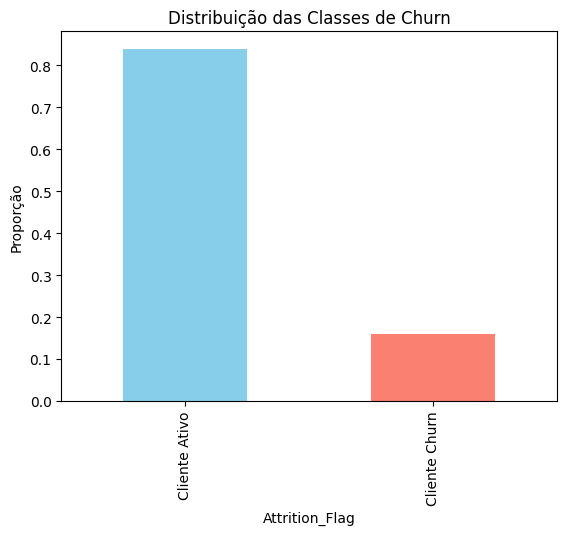

In [3]:
ax = df['Attrition_Flag'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
ax.set_title("Distribuição das Classes de Churn")
ax.set_xticklabels(['Cliente Ativo', 'Cliente Churn'])
plt.ylabel("Proporção")
plt.show()


# ## 5. Correlação entre Variáveis Numéricas

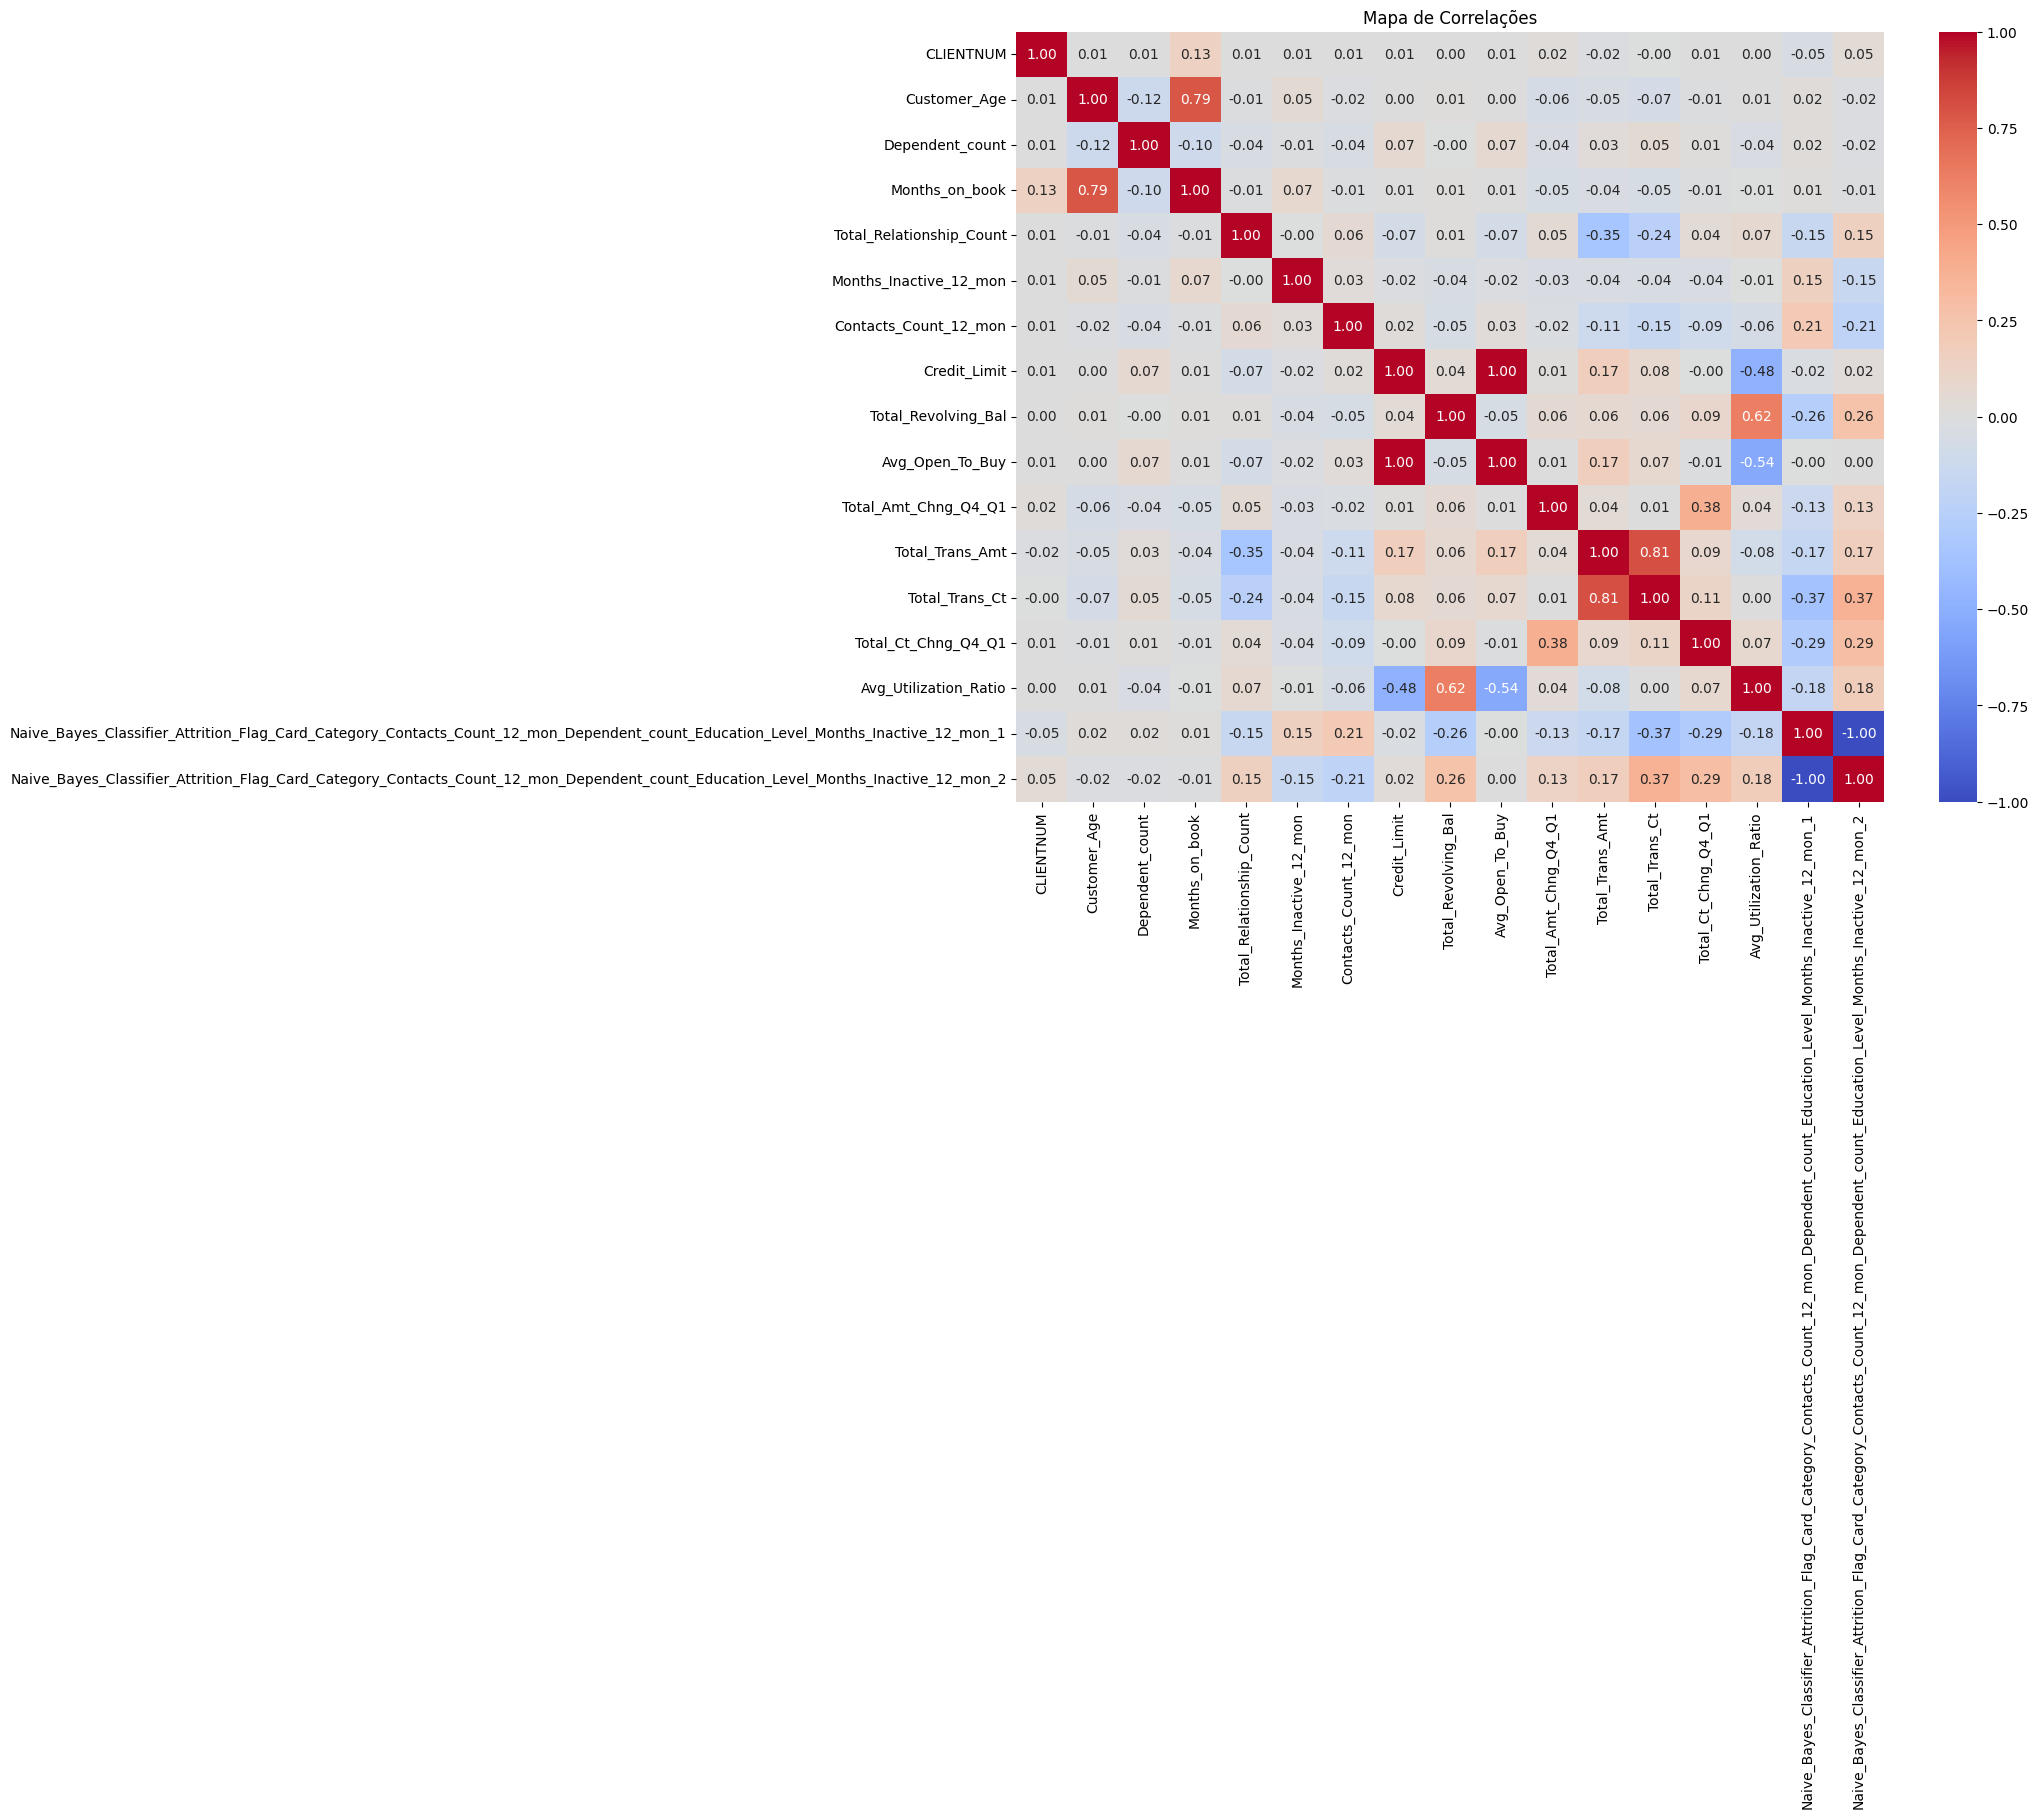

In [4]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlações")
plt.show()

# ## 6. Distribuição das Variáveis Criadas

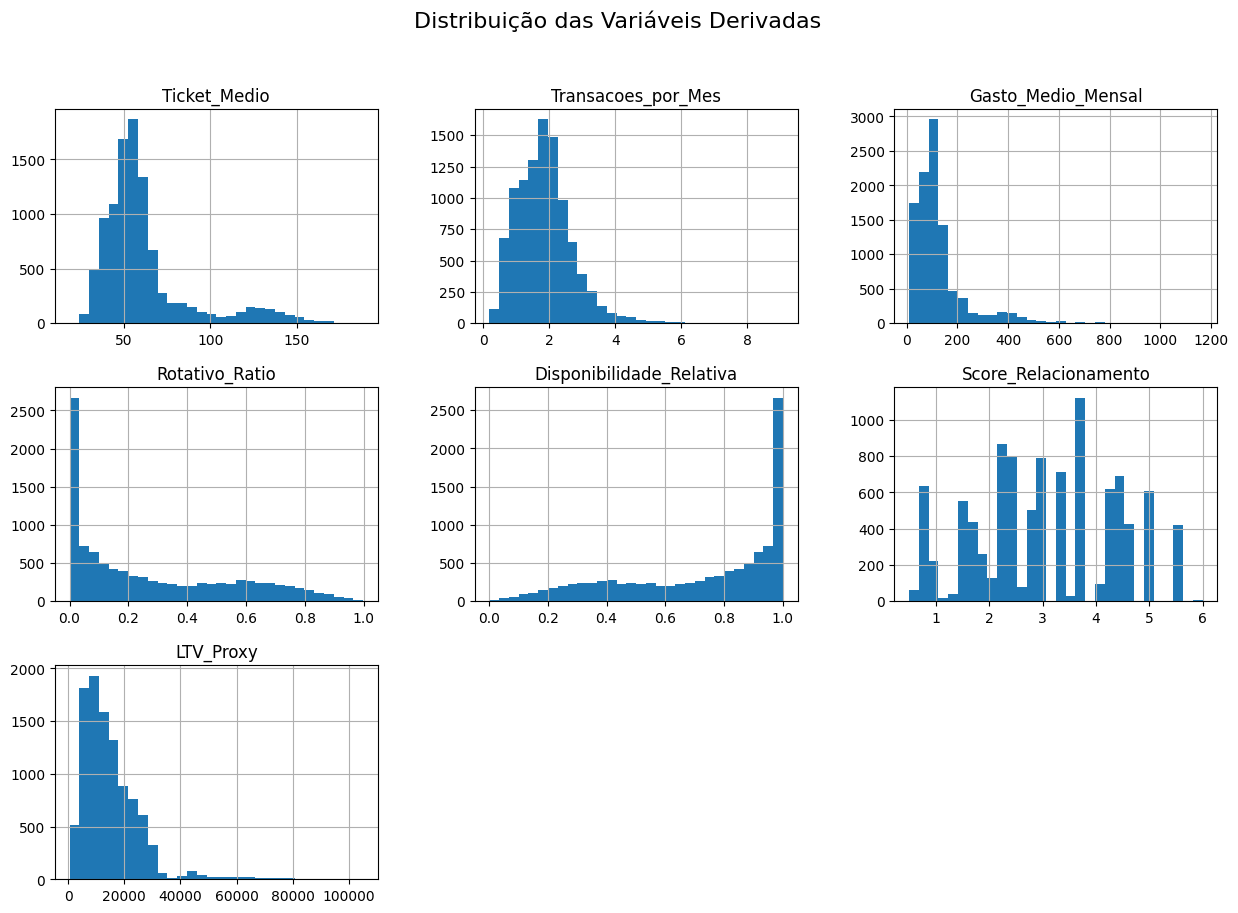

In [5]:
# Create derived variables
df['Ticket_Medio'] = df['Total_Trans_Amt'] / (df['Total_Trans_Ct'] + 1)  # Avoid division by zero
df['Transacoes_por_Mes'] = df['Total_Trans_Ct'] / (df['Months_on_book'] + 1)
df['Gasto_Medio_Mensal'] = df['Total_Trans_Amt'] / (df['Months_on_book'] + 1)
df['Rotativo_Ratio'] = df['Total_Revolving_Bal'] / (df['Credit_Limit'] + 1)
df['Disponibilidade_Relativa'] = df['Avg_Open_To_Buy'] / (df['Credit_Limit'] + 1)
df['Score_Relacionamento'] = df['Total_Relationship_Count'] * (1 - df['Months_Inactive_12_mon'] / 12)
df['LTV_Proxy'] = df['Total_Trans_Amt'] * df['Total_Relationship_Count']

variaveis_derivadas = [
    'Ticket_Medio', 'Transacoes_por_Mes', 'Gasto_Medio_Mensal',
    'Rotativo_Ratio', 'Disponibilidade_Relativa', 'Score_Relacionamento',
    'LTV_Proxy'
]
df[variaveis_derivadas].hist(figsize=(15,10), bins=30)
plt.suptitle("Distribuição das Variáveis Derivadas", fontsize=16)
plt.show()

# ## 7. PCA - Análise de Componentes Principais

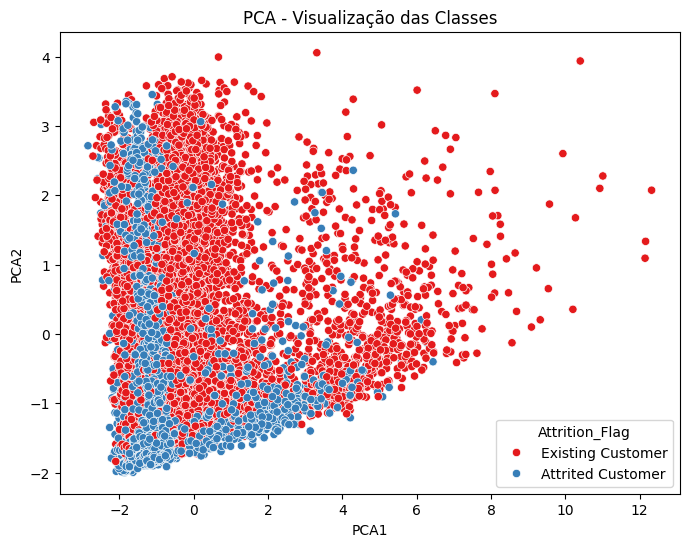

In [6]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[variaveis_derivadas])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df['PCA1'] = pca_result[:,0]
df['PCA2'] = pca_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Attrition_Flag', palette='Set1')
plt.title("PCA - Visualização das Classes")
plt.show()

# ## 8. Clusterização com KMeans

c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Iago\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Iago\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,

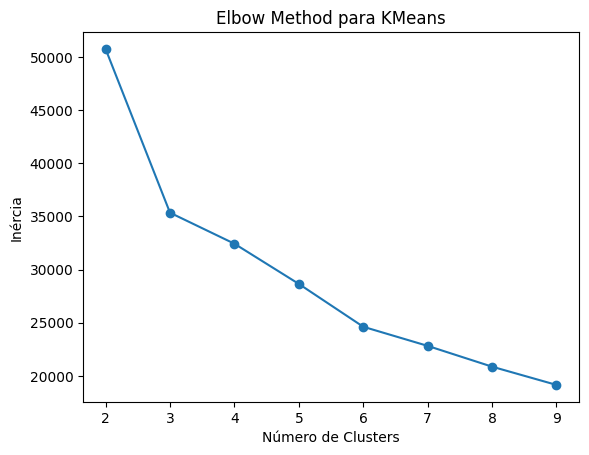

In [7]:
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss, marker='o')
plt.title("Elbow Method para KMeans")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.show()


# Cluster final

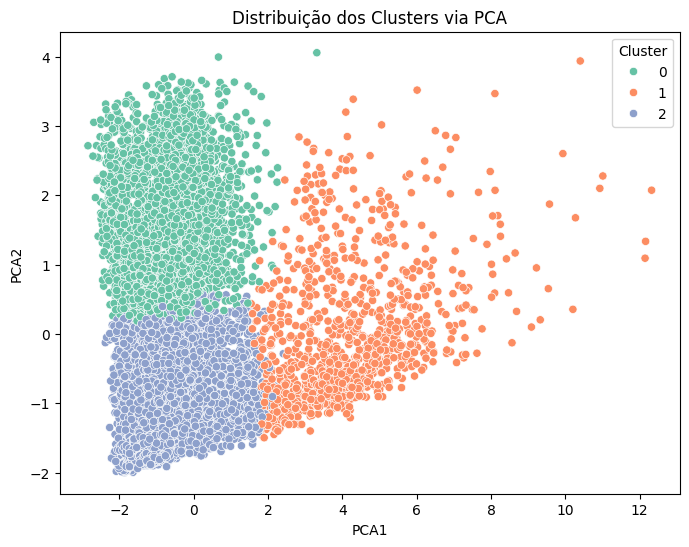

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Distribuição dos Clusters via PCA")
plt.show()

# ## 9. Conclusões Preliminares

"""
- As classes estão desbalanceadas (~84% vs. 16%).
- Score_Relacionamento e Total_Trans_Ct são fortes candidatos a bons preditores.
- PCA mostra separabilidade clara entre alguns perfis.
- KMeans indicou 3 clusters distintos, o que pode apoiar a análise comportamental.
"""